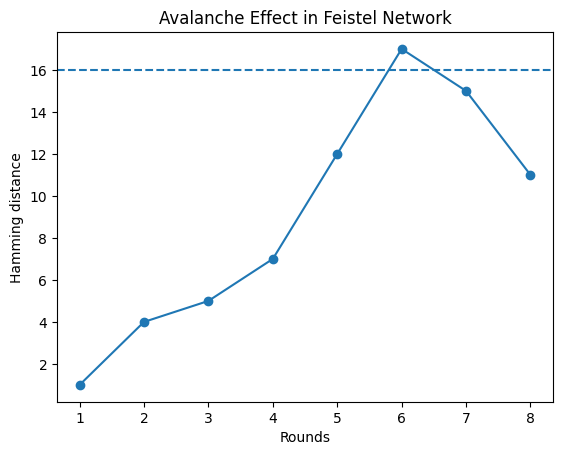

In [4]:
import numpy as np

class FeistelCipher:
    def __init__(self, round_keys):
        self.round_keys = round_keys
        self.num_rounds = len(round_keys)

    def _round_function(self, right, key):
        MASK_16=0xFFFF
        x = right ^ key          # key mixing
        x = (x + (x << 3)) & MASK_16
        x = x ^ (x >> 5)
        return x & MASK_16

    def encrypt_block(self, block):
        """
        block: 32-bit integer
        returns: 32-bit integer
        """
        # TODO: split block into L and R
        # TODO: perform Feistel rounds
        # TODO: recombine and return
        def single_round(block, key):
            left  = block >> 16
            right = block & 0xFFFF
            new_right = (self._round_function(right, key) ^ left) & 0xFFFF
            return (right << 16) | new_right
        new_block=block
        for k in self.round_keys:
            new_block=single_round(new_block, k)
        return new_block

    def decrypt_block(self, block):
        """
        block: 32-bit integer
        returns: 32-bit integer
        """
        # TODO: same structure as encrypt,
        #       but round keys reversed
        def single_round(block, key):
            left  = block >> 16
            right = block & 0xFFFF
            new_right = (self._round_function(right, key) ^ left) & 0xFFFF
            return (right << 16) | new_right
        new_block=block
        for k in reversed(self.round_keys):
            new_block=single_round(new_block, k)
        return new_block

import random
import matplotlib.pyplot as plt

import random
import matplotlib.pyplot as plt

def hamming_distance(x, y):
    return bin(x ^ y).count("1")


def encrypt_block_rounds(cipher, block, rounds):
    def single_round(block, key):
        left  = block >> 16
        right = block & 0xFFFF
        new_right = (cipher._round_function(right, key) ^ left) & 0xFFFF
        return (right << 16) | new_right

    new_block = block
    for k in cipher.round_keys[:rounds]:
        new_block = single_round(new_block, k)
    return new_block


def avalanche_test(cipher, base_block, flip_bit):
    flipped_block = base_block ^ (1 << flip_bit)

    distances = []
    for r in range(1, cipher.num_rounds + 1):
        c1 = encrypt_block_rounds(cipher, base_block, r)
        c2 = encrypt_block_rounds(cipher, flipped_block, r)
        distances.append(hamming_distance(c1, c2))

    return distances


def avalanche_test(cipher, base_block, flip_bit):
    flipped_block = base_block ^ (1 << flip_bit)

    distances = []
    for r in range(1, cipher.num_rounds + 1):
        c1 = encrypt_block_rounds(cipher, base_block, r)
        c2 = encrypt_block_rounds(cipher, flipped_block, r)
        distances.append(hamming_distance(c1, c2))

    return distances

round_keys = [0x1234, 0x5678, 0x9ABC, 0xDEF0,
              0x1111, 0x2222, 0x3333, 0x4444]

cipher = FeistelCipher(round_keys)

base_block = random.getrandbits(32)
flip_bit = random.randint(0, 31)

distances = avalanche_test(cipher, base_block, flip_bit)

plt.plot(range(1, len(distances) + 1), distances, marker='o')
plt.axhline(16, linestyle='--')  # ideal avalanche (half of 32 bits)
plt.xlabel("Rounds")
plt.ylabel("Hamming distance")
plt.title("Avalanche Effect in Feistel Network")
plt.show()


In [5]:
import random

from itertools import product

def recover_key_exhaustive(
    plaintext_ciphertext_pairs,
    keyspace_iter,
    num_rounds,
):
    """
    plaintext_ciphertext_pairs: list of (m, c) 32-bit ints
    keyspace_iter: iterable yielding candidate round_keys lists (length=num_rounds)
    num_rounds: number of rounds (len(round_keys))

    returns: the first matching round_keys, or None if no key found
    """
    # Small speed trick: localize for faster lookups in Python loops
    pairs = plaintext_ciphertext_pairs

    for candidate_round_keys in keyspace_iter:
        cipher = FeistelCipher(candidate_round_keys)

        ok = True
        for m, c in pairs:
            if cipher.encrypt_block(m) != c:
                ok = False
                break

        if ok:
            return candidate_round_keys

    return None

def keyspace_r_rounds_16bit(num_rounds):
    for ks in product(range(0x0000, 0x10000), repeat=num_rounds):
        yield list(ks)

def keyspace_r_rounds_kbits(num_rounds, k_bits):
    limit = 1 << k_bits
    for ks in product(range(limit), repeat=num_rounds):
        yield [k & 0xFFFF for k in ks]  # embed in 16-bit words

def derive_round_keys_from_master(master_key, num_rounds):
    x = master_key & 0xFFFFFFFF
    round_keys = []
    for _ in range(num_rounds):
        # xorshift32
        x ^= (x << 13) & 0xFFFFFFFF
        x ^= (x >> 17) & 0xFFFFFFFF
        x ^= (x <<  5) & 0xFFFFFFFF
        round_keys.append(x & 0xFFFF)
    return round_keys

def keyspace_master_key_32bit(num_rounds, max_master_key):
    for mk in range(max_master_key):   # e.g. 2**24
        yield derive_round_keys_from_master(mk, num_rounds)
def recover_master_key_exhaustive(pairs, num_rounds, max_master_key):
    for mk in range(max_master_key):
        round_keys = derive_round_keys_from_master(mk, num_rounds)
        cipher = FeistelCipher(round_keys)
        if all(cipher.encrypt_block(m) == c for m, c in pairs):
            return mk, round_keys
    return None

# --- victim side ---
NUM_ROUNDS = 8
TRUE_MASTER_KEY = random.randrange(2**20)   # small so we can brute force quickly

true_round_keys = derive_round_keys_from_master(TRUE_MASTER_KEY, NUM_ROUNDS)
victim_cipher = FeistelCipher(true_round_keys)

# Create known-plaintext pairs
pairs = []
for _ in range(3):
    m = random.getrandbits(32)
    c = victim_cipher.encrypt_block(m)
    pairs.append((m, c))

print("True master key:", TRUE_MASTER_KEY)
print("True round keys:", [hex(k) for k in true_round_keys])

# --- attacker side ---
result = recover_master_key_exhaustive(pairs, NUM_ROUNDS, max_master_key=2**20)
print("Recovered:", result)


True master key: 409435
True round keys: ['0xa90d', '0xe9b8', '0x2285', '0x1d4e', '0x8ec9', '0x43dd', '0xb8d8', '0xcc7c']
Recovered: (409435, [43277, 59832, 8837, 7502, 36553, 17373, 47320, 52348])
